In [1]:
# Import necessary libraries
import torch
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from google.cloud import storage

# Import the custom dataset class
%run 'dataset.ipynb'  # Use the path to your dataset.ipynb file

2024-10-25 16:42:28.948256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-25 16:42:29.085517: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-25 16:42:29.954278: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/

Runing


In [2]:
# Define transformations for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Initialize datasets
train_dataset = BrainTumorDataset(mode='train', transform=train_transform)
val_dataset = BrainTumorDataset(mode='val', transform=val_transform)

# Initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and configure the Vision Transformer model
# Load the Vision Transformer model with ignore_mismatched_sizes=True
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=4, ignore_mismatched_sizes=True)
model.to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=3e-5)
criterion = nn.CrossEntropyLoss()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
    accuracy = correct / len(loader.dataset)
    return total_loss / len(loader), accuracy

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
    accuracy = correct / len(loader.dataset)
    return total_loss / len(loader), accuracy


In [5]:
epochs = 10
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

for epoch in range(epochs):
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1/10
Train Loss: 0.2333, Train Accuracy: 0.9167
Val Loss: 0.1108, Val Accuracy: 0.9630
Epoch 2/10
Train Loss: 0.0535, Train Accuracy: 0.9829
Val Loss: 0.0888, Val Accuracy: 0.9694
Epoch 3/10
Train Loss: 0.0321, Train Accuracy: 0.9904
Val Loss: 0.0481, Val Accuracy: 0.9858
Epoch 4/10
Train Loss: 0.0139, Train Accuracy: 0.9956
Val Loss: 0.1292, Val Accuracy: 0.9630
Epoch 5/10
Train Loss: 0.0192, Train Accuracy: 0.9927
Val Loss: 0.0765, Val Accuracy: 0.9829
Epoch 6/10
Train Loss: 0.0180, Train Accuracy: 0.9947
Val Loss: 0.0557, Val Accuracy: 0.9808
Epoch 7/10
Train Loss: 0.0218, Train Accuracy: 0.9936
Val Loss: 0.0384, Val Accuracy: 0.9872
Epoch 8/10
Train Loss: 0.0084, Train Accuracy: 0.9973
Val Loss: 0.0442, Val Accuracy: 0.9879
Epoch 9/10
Train Loss: 0.0049, Train Accuracy: 0.9984
Val Loss: 0.0453, Val Accuracy: 0.9886
Epoch 10/10
Train Loss: 0.0080, Train Accuracy: 0.9972
Val Loss: 0.0497, Val Accuracy: 0.9879


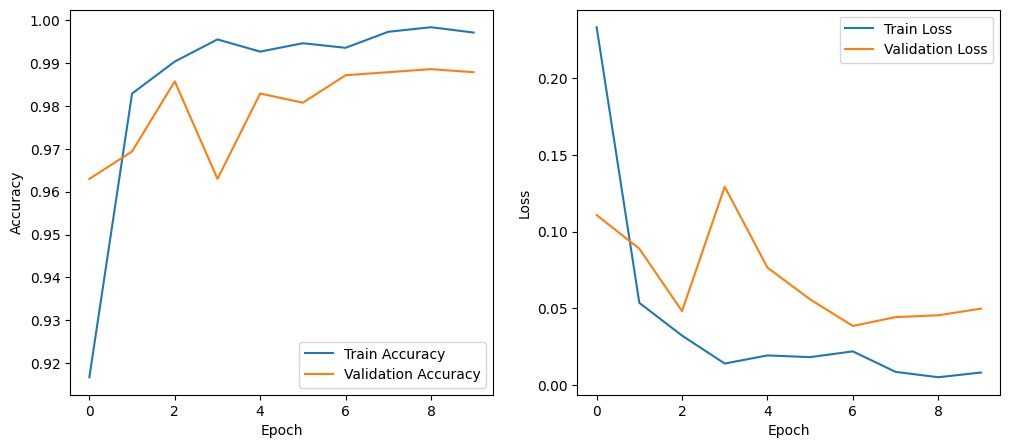

In [6]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [8]:
# Save the model locally first
model_save_path = "/tmp/vit_brain_tumor_model.pth"
torch.save(model.state_dict(), model_save_path)

# Define your GCS bucket and destination path
bucket_name = "virtual-machines-428917-us-notebooks" 
destination_blob_name = "models/vit_brain_tumor_model.pth"  # Path within the bucket

# Upload the model to GCS
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)
blob.upload_from_filename(model_save_path)

print(f"Model uploaded to gs://{bucket_name}/{destination_blob_name}")


Model uploaded to gs://virtual-machines-428917-us-notebooks/models/vit_brain_tumor_model.pth
